In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
# Hyperparams
ITERATIONS = 25
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02 #0.025 #0.02
STYLE_WEIGHT =4.5 #1. #4.5
TOTAL_VARIATION_WEIGHT = 1 #1e-4 #0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [0]:
# Paths
input_image_path = "input.png"
style_image_path = "style.png"
# output_image_name = "output"
# output_image_extender = ".png"
output_image_path = "output.png"
combined_image_path = "drive/My Drive/AIschool Team4/김도은/vgg16_19_combined.png"
vgg16_image_path = "vgg16.png"
vgg19_image_path = "vgg19.png"
inception_image_path = "inception.png"

# San Francisco
# san_francisco_image_path = "https://img.autobytel.com/car-reviews/autobytel/130992-10-2-door-luxury-cars-miles-branman/2016-Mercedes-AMG-GTS-FrontPassengerThree-QuarterView.jpg"
san_francisco_image_path = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"

# Warsaw by Tytus Brzozowski
# tytus_image_path = "https://dreamypixel.com/wp-content/uploads/2017/08/Starry-night-in-the-winter-mountains-1024x723.jpg"
tytus_image_path = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"


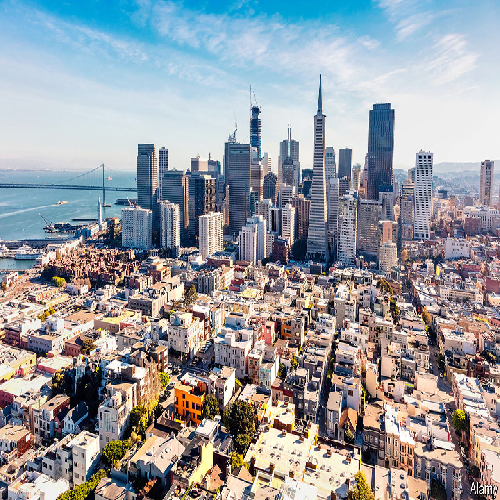

In [6]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

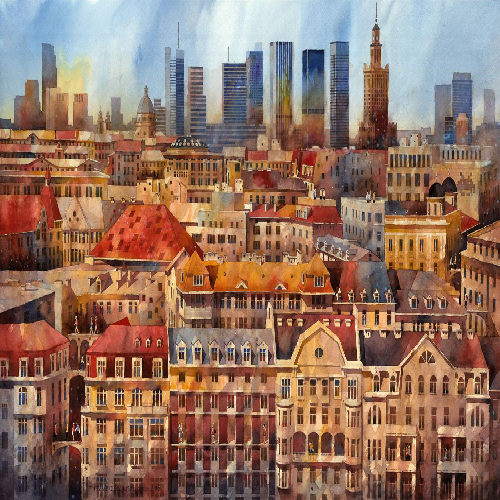

In [7]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [0]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [9]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model_19 = VGG19(input_tensor=input_tensor, include_top=False)

W0823 03:32:24.557605 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 03:32:24.561844 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 03:32:24.564642 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 03:32:24.593754 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 5s 0us/step


W0823 03:32:31.081912 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 03:32:31.083102 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
model_19.summary()
layers = dict([(layer.name, layer.output) for layer in model_19.layers])
layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 500, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 500, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 250, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 250, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 250, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 125, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_1/Relu:0' shape=(3, 125, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 62, 62, 

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

W0813 04:04:53.798567 140663576475520 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [0]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.
x

array([[[[ 1.13473935e+02, -3.25358867e+01, -3.52352489e+01],
         [-1.09532007e+02, -5.76531085e+01,  1.75302347e+01],
         [ 9.18460281e+01, -9.96827976e+00,  2.29420567e+01],
         ...,
         [ 8.35313367e+01, -5.23039253e+01, -1.02450051e+02],
         [-3.02399791e+01, -1.13645642e+02, -3.08588859e+01],
         [ 3.79003560e+01,  1.10934009e+02, -1.23830428e+02]],

        [[ 6.78155910e+01, -3.90364840e+01, -4.59394999e+01],
         [-6.15820427e+01, -1.92516285e+01,  5.20680121e+00],
         [ 1.23901760e+02, -8.28319554e+01,  4.41417718e+01],
         ...,
         [-2.17312887e+01, -3.06610977e+01, -8.90497587e+00],
         [ 7.32663238e-02,  5.29882372e+00,  1.13725563e+02],
         [-1.67864022e+01, -9.20259120e+01,  6.22141464e+01]],

        [[ 3.20702251e+01,  1.04438437e+02,  5.28434050e+01],
         [-2.13793236e+01, -4.63706317e+01,  1.04737179e+01],
         [-7.31643752e+01,  6.17738539e+01, -3.47992309e+01],
         ...,
         [ 1.25979856e+0

In [0]:
vgg19_loss_list = []
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    # print("info", info)
    vgg19_loss_list.append(loss)
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)

output_image.save(vgg19_image_path)
output_image
vgg19_loss_list


In [0]:
'''Resetting everything to VGG16'''
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model_16 = VGG16(input_tensor=input_tensor, include_top=False)


model_16.summary()
layers = dict([(layer.name, layer.output) for layer in model_16.layers])
layers

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
  

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss
    
    
    
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)


outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

#noise
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.


In [0]:
vgg16_loss_list = []
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    # print("info", info)
    vgg16_loss_list.append(loss)
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)

output_image.save(vgg16_image_path)
output_image
vgg16_loss_list

From here this is INCEPTION!!!!!!

In [10]:
'''Resetting everything to Inception'''
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

# input_tensor = tf.concat([input_image,style_image,combination_image], axis=0)
input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model_inception = InceptionV3(input_tensor=input_tensor, include_top=False)

# model_inception.summary()
layers = dict([(layer.name, layer.output) for layer in model_inception.layers])
layers

W0823 03:32:46.759067 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0823 03:32:47.608168 140075680851840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



87916544/87910968 [==============================] - 6s 0us/step


{'activation_1': <tf.Tensor 'activation_1/Relu:0' shape=(3, 249, 249, 32) dtype=float32>,
 'activation_10': <tf.Tensor 'activation_10/Relu:0' shape=(3, 60, 60, 96) dtype=float32>,
 'activation_11': <tf.Tensor 'activation_11/Relu:0' shape=(3, 60, 60, 96) dtype=float32>,
 'activation_12': <tf.Tensor 'activation_12/Relu:0' shape=(3, 60, 60, 32) dtype=float32>,
 'activation_13': <tf.Tensor 'activation_13/Relu:0' shape=(3, 60, 60, 64) dtype=float32>,
 'activation_14': <tf.Tensor 'activation_14/Relu:0' shape=(3, 60, 60, 48) dtype=float32>,
 'activation_15': <tf.Tensor 'activation_15/Relu:0' shape=(3, 60, 60, 64) dtype=float32>,
 'activation_16': <tf.Tensor 'activation_16/Relu:0' shape=(3, 60, 60, 64) dtype=float32>,
 'activation_17': <tf.Tensor 'activation_17/Relu:0' shape=(3, 60, 60, 96) dtype=float32>,
 'activation_18': <tf.Tensor 'activation_18/Relu:0' shape=(3, 60, 60, 96) dtype=float32>,
 'activation_19': <tf.Tensor 'activation_19/Relu:0' shape=(3, 60, 60, 64) dtype=float32>,
 'activati

In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_layer = 'mixed5'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
  

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["mixed5", "mixed6"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss
    
    
    
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)


outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

#noise
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.


W0823 03:33:24.355258 140075680851840 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.
W0823 03:33:24.496667 140075680851840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 0 completed with loss 27569896
Iteration 1 completed with loss 11552685
Iteration 2 completed with loss 10554128
Iteration 3 completed with loss 10195510
Iteration 4 completed with loss 10002594
Iteration 5 completed with loss 9881997
Iteration 6 completed with loss 9799202
Iteration 7 completed with loss 9741344
Iteration 8 completed with loss 9699770
Iteration 9 completed with loss 9667664
Iteration 10 completed with loss 9641875
Iteration 11 completed with loss 9620847
Iteration 12 completed with loss 9602942
Iteration 13 completed with loss 9587729
Iteration 14 completed with loss 9574907
Iteration 15 completed with loss 9564000
Iteration 16 completed with loss 9556006
Iteration 17 completed with loss 9550271
Iteration 18 completed with loss 9545782
Iteration 19 completed with loss 9542248
Iteration 20 completed with loss 9539502
Iteration 21 completed with loss 9537197
Iteration 22 completed with loss 9535233
Iteration 23 completed with loss 9533772
Iteration 24 complete

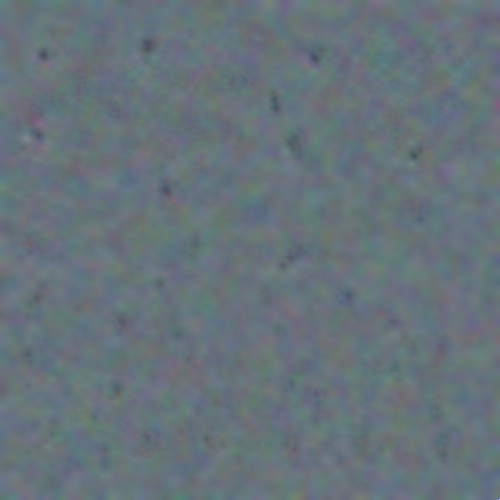

In [12]:
inception_loss_list = []
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    # print("info", info)
    inception_loss_list.append(loss)
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)

output_image.save(inception_image_path)
output_image
# inception_loss_list

In [13]:
inception_loss_list

[27569896.0,
 11552685.0,
 10554128.0,
 10195510.0,
 10002594.0,
 9881997.0,
 9799202.0,
 9741344.0,
 9699770.0,
 9667664.0,
 9641875.0,
 9620847.0,
 9602942.0,
 9587729.0,
 9574907.0,
 9564000.0,
 9556006.0,
 9550271.0,
 9545782.0,
 9542248.0,
 9539502.0,
 9537197.0,
 9535233.0,
 9533772.0,
 9532740.0]

VISUALISATION!!!!!

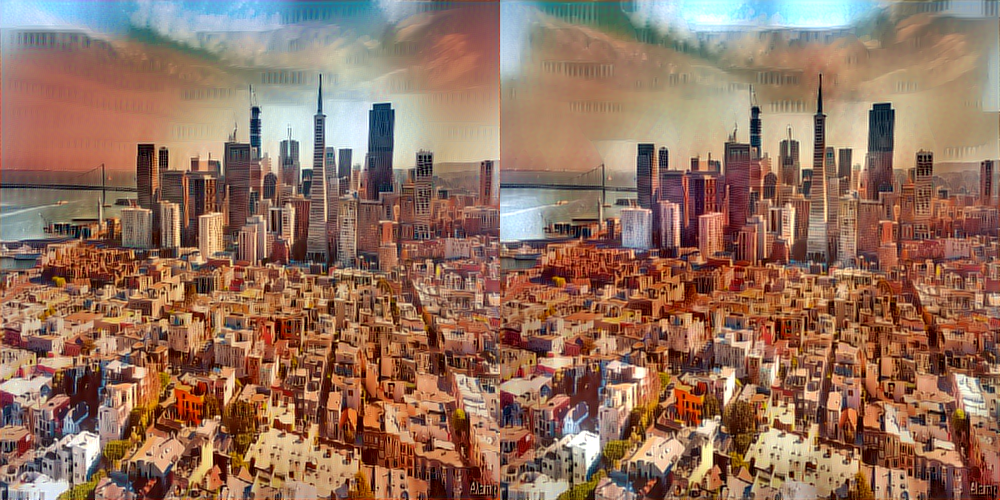

In [0]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [vgg16_image_path, vgg19_image_path, inception_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined

Plotting Loss graphs


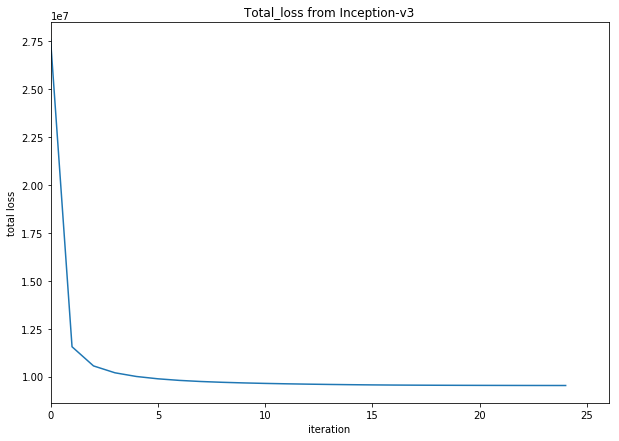

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
# ax.set_title('Total_loss comparison between VGG16 and VGG19')
# ax.set_title('Total_loss from VGG19')
# ax.plot([x for x in range(25)], vgg19_loss_list)
# vgg19_loss_list =[79797576000.0,
#  37885000000.0,
#  26525932000.0,
#  21597348000.0,
#  18406062000.0,
#  16630168000.0,
#  15503004000.0,
#  14734221000.0,
#  14071810000.0,
#  13385353000.0,
#  12901496000.0,
#  12492233000.0,
#  12214034000.0,
#  11997569000.0,
#  11747510000.0,
#  11568943000.0,
#  11411274000.0,
#  11267546000.0,
#  11164138000.0,
#  11069661000.0,
#  11004295000.0,
#  10934219000.0,
#  10879690000.0,
#  10832480000.0,
#  10780969000.0]


# ax.plot([x for x in range(ITERATIONS)], vgg16_loss_list)
# vgg16_loss_list =
# [100368770000.0,
#  39965344000.0,
#  28319744000.0,
#  24405154000.0,
#  22905680000.0,
#  22104498000.0,
#  21646910000.0,
#  21363913000.0,
#  21188760000.0,
#  21048562000.0,
#  20936410000.0,
#  20834144000.0,
#  20731396000.0,
#  20629193000.0,
#  20530862000.0,
#  20436066000.0,
#  20349990000.0,
#  20273306000.0,
#  20201570000.0,
#  20141167000.0,
#  20090400000.0,
#  20047147000.0,
#  20010619000.0,
#  19978854000.0,
#  19950560000.0]

ax.set_title('Total_loss from Inception-v3')
ax.plot([x for x in range(ITERATIONS)], inception_loss_list)


plt.xlabel('iteration')
plt.ylabel('total loss')
plt.xlim(0, 25+1)
# plt.legend('VGG19')
plt.savefig("drive/My Drive/AIschool Team4/김도은/loss_graphs/total_loss_from Inception-v3_1")